# <b>Project #3 - Classification</b>

## <b>Import used packages</b>

In [87]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, DBSCAN
import re

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

## <b>Loading data from - in our case it is a csv file</b>

In [88]:
df_full = pd.read_csv('./water_potability.csv', sep=',') 
df_full

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


## <b>Let's take a look at the basic dataset information</b>

### <b>Dataset columns?</b>
- ph: pH of water
- Hardness: Capacity of water to precipitate soap in mg/L
- Solids: Total dissolved solids in ppm
- Chloramines: Amount of Chloramines in ppm
- Sulfate: Amount of Sulfates dissolved in mg/L
- Conductivity: Electrical conductivity of water in μS/cm
- Organic_carbon: Amount of organic carbon in ppm
- Trihalomethanes: Amount of Trihalomethanes in μg/L
- Turbidity: Measure of light emiting property of water in NTU (Nephelometric Turbidity Units)
- Potability: Indicates if water is safe for human consumption



### <b>How many samples are potable? (drinkable)</b>
- Ratio is 1998/1278, more samples is not potable
    - Dataset is slightly imbalanced

In [89]:
df_full.Potability.value_counts()

0    1998
1    1278
Name: Potability, dtype: int64

### <b>Dataset shape?</b>
- 10 cols, 3276 rows


In [90]:
df_full.shape

(3276, 10)

### <b>Let's check datatypes</b>
- all are numerical, which is great

In [91]:
df_full.dtypes

ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object

### <b>Are there any missing values?</b>
- Mostly not, a few columns have some missing values
- Ratio of missing values is low, i think it's ok to fill them with mean

In [92]:
df_full.isna().sum().sort_values()

Hardness             0
Solids               0
Chloramines          0
Conductivity         0
Organic_carbon       0
Turbidity            0
Potability           0
Trihalomethanes    162
ph                 491
Sulfate            781
dtype: int64

### <b>Let's fill missing values with mean or remove them</b>

In [93]:
trihalomethanes_mean_value=df_full['Trihalomethanes'].mean()
df_full['Trihalomethanes'].fillna(value=trihalomethanes_mean_value, inplace=True)

ph_mean_value=df_full['ph'].mean()
df_full['ph'].fillna(value=ph_mean_value, inplace=True)

sulfate_mean_value=df_full['Sulfate'].mean()
df_full['Sulfate'].fillna(value=sulfate_mean_value, inplace=True)

## <b>If we want to use Classification algorithm, we gotta work with numeric values only, we've just checked it out, we have numerical values only, so dataset is ready

## <b>Let's start with splitting the data into the input and output part </b>
- I'll name variables X and y as usual

In [94]:
X, y = df_full.loc[:, df_full.columns != 'Potability'], df_full.loc[:, 'Potability']

In [95]:
X.head()


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,7.080795,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135
1,3.716080,129.422921,18630.057858,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656
2,8.099124,224.236259,19909.541732,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075


In [96]:
y.head()


0    0
1    0
2    0
3    0
4    0
Name: Potability, dtype: int64

## <b>Lets continue with train test split process</b>

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2620, 9), (656, 9), (2620,), (656,))

## <b>Create the Decision tree classifier instance</b>

In [98]:
clf = DecisionTreeClassifier()

In [99]:
clf.fit(X_train, y_train)

DecisionTreeClassifier()

## <b>Use *fit()* method for training of classifier</b>

In [100]:
y_pred = clf.predict(X_test)
y_pred

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,

## <b>Let's check the result with confusion matrix</b>
- TP -> The prediction was true and the reality is true
- FP -> The prediction was true and the reality is false
- FN -> The prediction was false and the reality is false
- TN -> The prediction was false and the reality is true

$ConfMatrix = \begin{bmatrix}
TP & FN\\
FP & TN
\end{bmatrix}$

<AxesSubplot: >

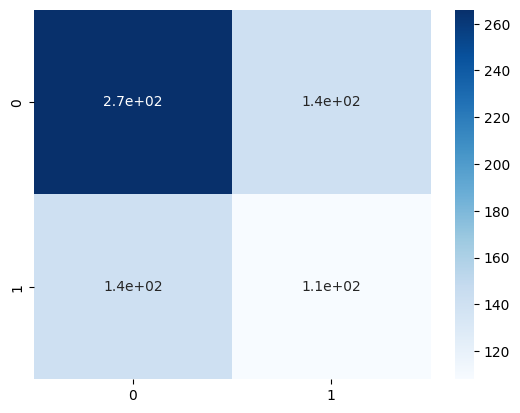

In [101]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues")

In [102]:
confusion_matrix(y_test, y_pred)

array([[266, 141],
       [141, 108]], dtype=int64)

In [103]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(266, 141, 141, 108)

## <b>Which metric would be the best choice?</b>
- <b>Accuracy score</b>
    - I would choose it if dataset is more balanced and we are interested in predicting both 0 and 1 correctly
- <b>F1 score</b>
    - This is the harmonic mean of Precision and Recall and gives a better measure of the incorrectly classified cases than the Accuracy Metric
- <b>Precision score</b>
    - We use precision when we want the prediction of 1 to be as correct as possible and we don't care about 0
- <b>Recall score</b>
    - We use precision when we want our model to spot as many real 1 as possible

### <b>I was deciding between accuracy and f1 score, but if the number of false negatives is the same as the number of false positives, accuracy gets better results. </b>


In [104]:
accuracy_score(y_test, y_pred)

0.5701219512195121

In [105]:
precision_score(y_test, y_pred)

0.43373493975903615

In [106]:
recall_score(y_test, y_pred)

0.43373493975903615

In [107]:
f1_score(y_test, y_pred)

0.43373493975903615

## <b>Now let's try some classification methods to improve our evaluation process</b>
- #### Because our data are slightly balanced, I've tried both KFold and StratisfiedKFold, KFold had better result, so I've decided to work with KFold only

### <b>DecisionTree</b>
- I got better results with Stra

In [146]:
skf = KFold(n_splits=5)
scores = list()
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    print(f'Survival ratio in train set: {y_train.value_counts(normalize=True)[1]:.2}; Survival ratio in test set: {y_test.value_counts(normalize=True)[1]:.2}')
    
np.mean(scores), np.min(scores), np.max(scores)

Survival ratio in train set: 0.39; Survival ratio in test set: 0.39
Survival ratio in train set: 0.39; Survival ratio in test set: 0.39
Survival ratio in train set: 0.39; Survival ratio in test set: 0.39
Survival ratio in train set: 0.39; Survival ratio in test set: 0.39
Survival ratio in train set: 0.39; Survival ratio in test set: 0.39


(0.5802871904673245, 0.5404580152671755, 0.6045801526717557)

### <b>RandomForest</b>

In [148]:
skf = KFold(n_splits=5)
scores = list()
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = RandomForestClassifier(max_depth=200, warm_start=True )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    
np.mean(scores), np.min(scores), np.max(scores)

(0.6251615155464532, 0.5960365853658537, 0.6580152671755726)

### <b>MLPClassifier</b>

In [149]:
skf = KFold(n_splits=5)
scores = list()
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = MLPClassifier(activation='logistic', shuffle=False)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
np.mean(scores), np.min(scores), np.max(scores)


(0.6098910817352448, 0.6067073170731707, 0.6122137404580152)

### <b>4rd classifier TODO</b>

## <b>Final report</b>